In [113]:
#!pip install --user pyarrow
#!pip install --user -U pandas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
conservation = pd.read_csv("../data/vep/conservation/Chr5.tsv.gz", sep="\t")
conservation

,pos,PhastCons,PhyloP
0,73,0.137841,0.486723
1,74,0.120058,0.630370
2,75,0.082986,-0.672660
3,76,0.083501,0.630370
4,77,0.070315,0.410230
...,...,...,...
24279498,26975493,0.149043,0.383414
24279499,26975494,0.139126,0.383414
24279500,26975495,0.121064,-0.819180
24279501,26975496,0.144156,0.383414


In [3]:
def compute_odds_ratio(df, threshold_quantile, print_table=False):
    df = df.copy()
    threshold = df.model_score.quantile(threshold_quantile)
    df.loc[df.model_score <= threshold, "ModelScoreTier"] = "Low"
    df.loc[df.model_score > threshold, "ModelScoreTier"] = "High"
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    group_counts = df.groupby(["Status", "ModelScoreTier"]).size()
    
    #print("Adding 1 pseudocount")
    #group_counts += 1
    if print_table:
        print(group_counts)
    
    group_counts2 = group_counts.copy()
    #print(threshold_quantile, threshold, group_counts["Rare", "Low"]+group_counts["Common", "Low"], df.model_score.min())
    group_counts = group_counts.values.reshape((2, 2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts


def compute_vep_scores(model_name):
    print(model_name)
    if model_name in ["PhastCons", "PhyloP", "PhyloP_ReLU", "PhyloP_abs"]:
        df = pd.read_parquet("../data/vep/variants/filt.parquet")
    else:
        vep_mode, model_name2 = model_name.split("/")
        df = pd.read_parquet(f"../plantbert/{vep_mode}/vep_full_{model_name2}.parquet")
    df = df[df.AN >= 2000]
    df = df[(df.AC != 0) & (df.AC != df.AN)]
    df["AF"] = df.AC / df.AN
    df = df[df.AF < 0.5]
    df = df.merge(conservation, how="inner", on="pos")
    df.consequence = df.consequence.apply(lambda x: ','.join(sorted(list(set(x.split(","))))))
    
    # TODO: figure this out
    #df.loc[(df.dist_to_TSS >= -1000) & (df.dist_to_TSS <= 0) & (df.consequence=="upstream_gene_variant"), "consequence"] = "upstream_1kb"
    
    # TODO: for loop
    #rare_thresholds = np.arange(2, 12, 2)
    #common_thresholds = np.arange(10, 110, 10)
    
    df["Status"] = "Neither"
    df.loc[df.AC <= 2, "Status"] = "Rare"
    df.loc[df.AC >= 20, "Status"] = "Common"
    df = df[df.Status!="Neither"]
    df.Status = df.Status.astype('category')
    print(df.Status.value_counts())
    #raise Exception("debug")
    
    if model_name == "PhastCons":
        df["model_score"] = -df.PhastCons
    elif model_name == "PhyloP":
        df["model_score"] = -(df.PhyloP)
    elif model_name == "PhyloP_abs":
        df["model_score"] = -(df.PhyloP.abs())
    elif model_name == "PhyloP_ReLU":
        df["model_score"] = -(df.PhyloP.clip(lower=0.0))
    elif vep_mode == "chromatin":
        pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
        pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
        pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
        df[pred_cols] = sigmoid(df[pred_cols])
        feature_names = ["_".join(col.split("_")[3:]) for col in pred_ref_cols]
        delta_pred_cols = [f"delta_pred_{f}" for f in feature_names]
        df.loc[:, delta_pred_cols] = df[pred_alt_cols].values - df[pred_ref_cols].values
        df.loc[:, "model_score"] = -np.linalg.norm(df[delta_pred_cols].abs().values, ord=2, axis=1)
    elif vep_mode == "mlm":
        df["model_score"] = df.model_llr
        
    threshold_quantiles = np.logspace(-3, -1, 10)
    
    categories = ["all"] + df.consequence.value_counts()[:8].index.values.tolist()
    
    all_results = []
    for category in categories:
        #print(category)
        df_category = df if category == "all" else df[df.consequence==category]
        
        odds_ratios, p_values, min_counts = zip(*[compute_odds_ratio(df_category, threshold_quantile) for threshold_quantile in threshold_quantiles])
        results = pd.DataFrame(dict(threshold_quantile=threshold_quantiles, odds_ratio=odds_ratios, p_value=p_values, min_count=min_counts))
        results["Test"] = "Odds-ratio"
        
        results = results.append({
            "Test": "Mann-Whitney",
            "p_value": mannwhitneyu(df_category.loc[df.Status=="Rare", "model_score"], df_category.loc[df.Status=="Common", "model_score"], alternative="less").pvalue
        }, ignore_index=True)
        
        results = results.append({
            "Test": "AUROC",
            "AUROC": roc_auc_score((df_category.Status=="Rare").values, -df_category.model_score.values)
        }, ignore_index=True)
        
        precision, recall, thresholds = precision_recall_curve((df_category.Status=="Rare").values, -df_category.model_score.values)
        results = results.append({
            "Test": "AUPRC",
            "AUPRC": auc(recall, precision),
        }, ignore_index=True)
        
        results["Category"] = category
        all_results.append(results)
    all_results = pd.concat(all_results, ignore_index=True)
    all_results["Model"] = model_name
    all_results["Significant"] = all_results.p_value < 0.05
    
    return all_results, df

In [20]:
model_names = [
    #"mlm/window-512_tokenization-no_model-convnet200k",
    #"mlm/window-512_tokenization-no_model-convnet",
    #"mlm/window-512_tokenization-no_model-convnet800k",
    #"mlm/window-512_tokenization-no_model-convnet800kfinetune150k",
    "mlm/window-512_tokenization-no_model-convnet800kfinetune200k",
    "mlm/window-512_tokenization-no_model-convnet_only_athaliana",
    #"mlm/DNABERT",
    #"chromatin/ConvNet",
    #"chromatin/DNABERT",
    #"chromatin/DeepSEA",
    #"PhastCons",
    "PhyloP",
    ####"PhyloP_ReLU",
    ####"PhyloP_abs",
]

results = pd.concat(
    [compute_vep_scores(model_name)[0] for model_name in model_names],
    ignore_index=True
)

mlm/window-512_tokenization-no_model-convnet800kfinetune200k
Rare      512513
Common    394733
Name: Status, dtype: int64
mlm/window-512_tokenization-no_model-convnet_only_athaliana
Rare      512513
Common    394733
Name: Status, dtype: int64
PhyloP
Rare      512513
Common    394733
Name: Status, dtype: int64


In [21]:
#results.to_csv(f"vep_metrics_2_20.tsv", sep="\t", index=False)
#results = pd.read_csv("vep_metrics_2_20.tsv", sep="\t")

In [29]:
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet200k": "mlm/ConvNet-200k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet": "mlm/ConvNet-400k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800k": "mlm/ConvNet-800k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800k": "mlm/ConvNet"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune150k": "mlm/ConvNet-finetune-athaliana"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune200k": "mlm/ConvNet"}, inplace=True)
results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune200k": "ConvNet (800k 20 species + 200k only Arabidopsis)"}, inplace=True)
results.Model.replace({"mlm/window-512_tokenization-no_model-convnet_only_athaliana": "ConvNet (500k only Arabidopsis)"}, inplace=True)

In [23]:
# deal with infinite odds ratio
results.odds_ratio.max()

4.047146289496351

In [24]:
results.odds_ratio.replace({np.inf: 20.0}, inplace=True)

In [25]:
results.odds_ratio.max()

4.047146289496351

In [72]:
#results = results[~(results.Model.isin(["PhyloP_abs", "PhyloP_ReLU"]))]

In [73]:
#results = results[results.Model.str.contains("mlm/ConvNet")]

In [6]:
#results = results[~results.Model.str.contains("00k")]

In [7]:
df = compute_vep_scores("mlm/window-512_tokenization-no_model-convnet800kfinetune200k")[1]

mlm/window-512_tokenization-no_model-convnet800kfinetune200k
Rare      512513
Common    394733
Name: Status, dtype: int64


In [8]:
consequence_value_counts = df.consequence.value_counts()

In [9]:
def get_category_n(category):
    if category == "all": return len(df)
    return consequence_value_counts[category]

In [27]:
results["category_n"] = results.Category + " (n=" + results.Category.apply(get_category_n).astype(str) + ")"
results.category_n

0                         all (n=907246)
1                         all (n=907246)
2                         all (n=907246)
3                         all (n=907246)
4                         all (n=907246)
                     ...                
346    downstream_gene_variant (n=30852)
347    downstream_gene_variant (n=30852)
348    downstream_gene_variant (n=30852)
349    downstream_gene_variant (n=30852)
350    downstream_gene_variant (n=30852)
Name: category_n, Length: 351, dtype: object

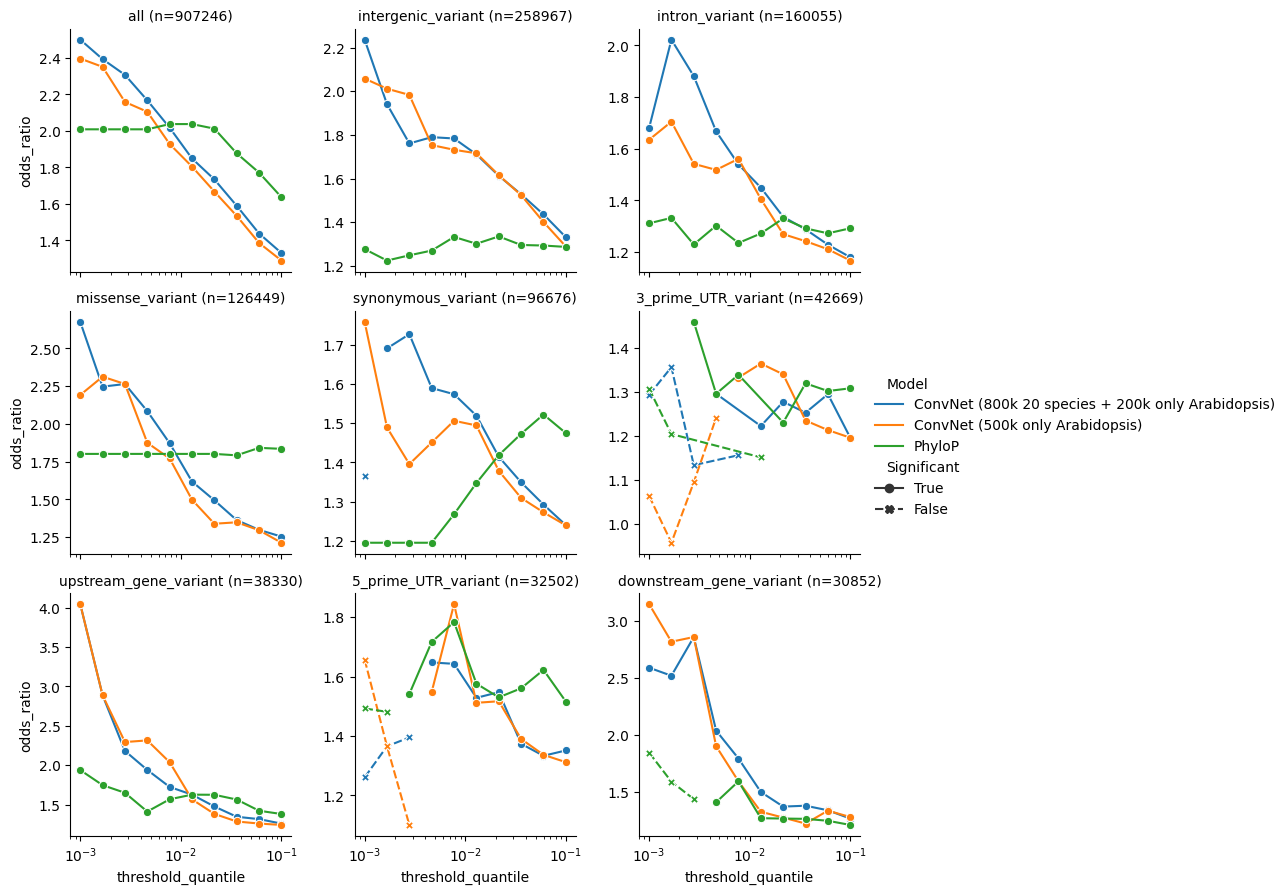

In [30]:
g = sns.relplot(
    data=results[(results.Test=="Odds-ratio")&(results.min_count >= 5)],
    x="threshold_quantile",
    y="odds_ratio",
    hue="Model",
    style="Significant",
    style_order=[True, False],
    col="category_n",
    height=3,
    #aspect=.7,
    kind="line",
    markers=True,
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': True}
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(xscale='log');
#plt.savefig("odds_ratios.svg", bbox_inches='tight')

In [13]:
results_mw = results[results.Test=="Mann-Whitney"]
results_mw

,threshold_quantile,odds_ratio,p_value,min_count,Test,AUROC,AUPRC,Category,Model,Significant,category_n
10,NaN,NaN,0.000000e+00,NaN,Mann-Whitney,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet800k,True,all (n=907246)
23,NaN,NaN,2.162283e-120,NaN,Mann-Whitney,NaN,NaN,intergenic_variant,mlm/window-512_tokenization-no_model-convnet800k,True,intergenic_variant (n=258967)
36,NaN,NaN,2.284253e-41,NaN,Mann-Whitney,NaN,NaN,intron_variant,mlm/window-512_tokenization-no_model-convnet800k,True,intron_variant (n=160055)
49,NaN,NaN,9.003874e-72,NaN,Mann-Whitney,NaN,NaN,missense_variant,mlm/window-512_tokenization-no_model-convnet800k,True,missense_variant (n=126449)
62,NaN,NaN,2.270359e-70,NaN,Mann-Whitney,NaN,NaN,synonymous_variant,mlm/window-512_tokenization-no_model-convnet800k,True,synonymous_variant (n=96676)
75,NaN,NaN,2.536930e-18,NaN,Mann-Whitney,NaN,NaN,3_prime_UTR_variant,mlm/window-512_tokenization-no_model-convnet800k,True,3_prime_UTR_variant (n=42669)
88,NaN,NaN,1.740205e-20,NaN,Mann-Whitney,NaN,NaN,upstream_gene_variant,mlm/window-512_tokenization-no_model-convnet800k,True,upstream_gene_variant (n=38330)
101,NaN,NaN,5.320739e-35,NaN,Mann-Whitney,NaN,NaN,5_prime_UTR_variant,mlm/window-512_tokenization-no_model-convnet800k,True,5_prime_UTR_variant (n=32502)
114,NaN,NaN,1.119037e-13,NaN,Mann-Whitney,NaN,NaN,downstream_gene_variant,mlm/window-512_tokenization-no_model-convnet800k,True,downstream_gene_variant (n=30852)
127,NaN,NaN,0.000000e+00,NaN,Mann-Whitney,NaN,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,True,all (n=907246)


In [14]:
results_mw["-log10_pvalue"] = results_mw.p_value.apply(lambda p_value: 300 if p_value==0.0 else -np.log10(p_value))

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Mann-Whitney -log10_pvalue')

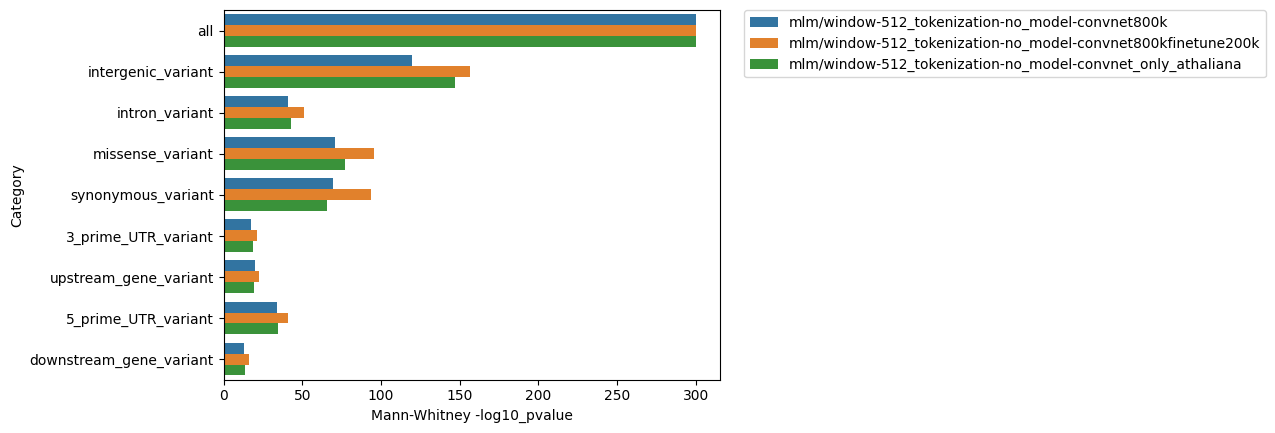

In [15]:
sns.barplot(
    y="Category",
    x="-log10_pvalue",
    hue="Model",
    data=results_mw,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Mann-Whitney -log10_pvalue")
#plt.savefig("mann_whitney.pdf", bbox_inches='tight')

In [16]:
results_auroc = results[results.Test=="AUROC"]
results_auroc

,threshold_quantile,odds_ratio,p_value,min_count,Test,AUROC,AUPRC,Category,Model,Significant,category_n
11,NaN,NaN,NaN,NaN,AUROC,0.530147,NaN,all,mlm/window-512_tokenization-no_model-convnet800k,False,all (n=907246)
24,NaN,NaN,NaN,NaN,AUROC,0.526847,NaN,intergenic_variant,mlm/window-512_tokenization-no_model-convnet800k,False,intergenic_variant (n=258967)
37,NaN,NaN,NaN,NaN,AUROC,0.519397,NaN,intron_variant,mlm/window-512_tokenization-no_model-convnet800k,False,intron_variant (n=160055)
50,NaN,NaN,NaN,NaN,AUROC,0.530033,NaN,missense_variant,mlm/window-512_tokenization-no_model-convnet800k,False,missense_variant (n=126449)
63,NaN,NaN,NaN,NaN,AUROC,0.532922,NaN,synonymous_variant,mlm/window-512_tokenization-no_model-convnet800k,False,synonymous_variant (n=96676)
76,NaN,NaN,NaN,NaN,AUROC,0.524398,NaN,3_prime_UTR_variant,mlm/window-512_tokenization-no_model-convnet800k,False,3_prime_UTR_variant (n=42669)
89,NaN,NaN,NaN,NaN,AUROC,0.527462,NaN,upstream_gene_variant,mlm/window-512_tokenization-no_model-convnet800k,False,upstream_gene_variant (n=38330)
102,NaN,NaN,NaN,NaN,AUROC,0.539881,NaN,5_prime_UTR_variant,mlm/window-512_tokenization-no_model-convnet800k,False,5_prime_UTR_variant (n=32502)
115,NaN,NaN,NaN,NaN,AUROC,0.524343,NaN,downstream_gene_variant,mlm/window-512_tokenization-no_model-convnet800k,False,downstream_gene_variant (n=30852)
128,NaN,NaN,NaN,NaN,AUROC,0.534513,NaN,all,mlm/window-512_tokenization-no_model-convnet80...,False,all (n=907246)


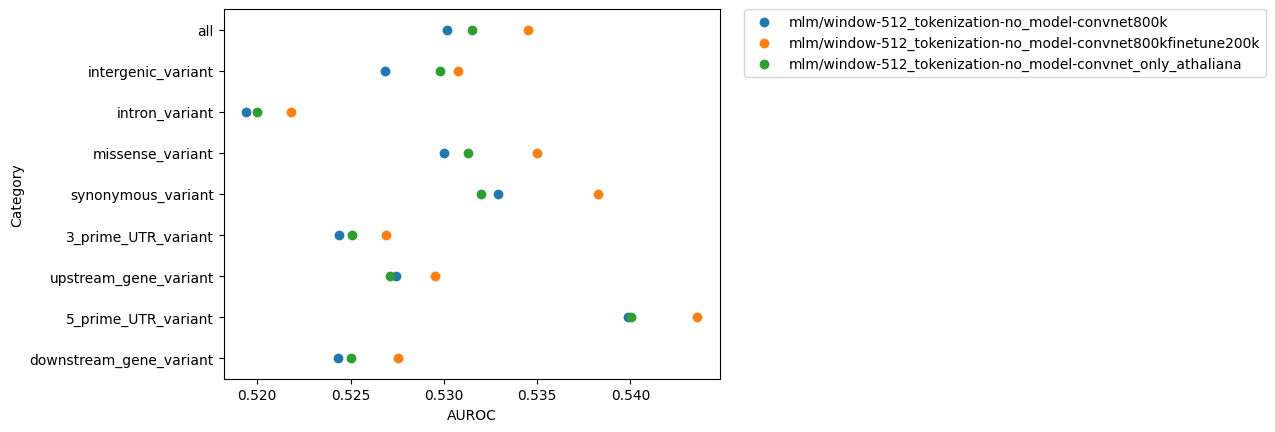

In [17]:
sns.pointplot(
    y="Category",
    x="AUROC",
    hue="Model",
    data=results_auroc,
    join=False,
    scale=0.8,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("auroc.pdf", bbox_inches='tight')

In [18]:
results_auprc = results[results.Test=="AUPRC"]
results_auprc

,threshold_quantile,odds_ratio,p_value,min_count,Test,AUROC,AUPRC,Category,Model,Significant,category_n
12,NaN,NaN,NaN,NaN,AUPRC,NaN,0.592283,all,mlm/window-512_tokenization-no_model-convnet800k,False,all (n=907246)
25,NaN,NaN,NaN,NaN,AUPRC,NaN,0.610368,intergenic_variant,mlm/window-512_tokenization-no_model-convnet800k,False,intergenic_variant (n=258967)
38,NaN,NaN,NaN,NaN,AUPRC,NaN,0.545402,intron_variant,mlm/window-512_tokenization-no_model-convnet800k,False,intron_variant (n=160055)
51,NaN,NaN,NaN,NaN,AUPRC,NaN,0.652177,missense_variant,mlm/window-512_tokenization-no_model-convnet800k,False,missense_variant (n=126449)
64,NaN,NaN,NaN,NaN,AUPRC,NaN,0.496982,synonymous_variant,mlm/window-512_tokenization-no_model-convnet800k,False,synonymous_variant (n=96676)
77,NaN,NaN,NaN,NaN,AUPRC,NaN,0.585136,3_prime_UTR_variant,mlm/window-512_tokenization-no_model-convnet800k,False,3_prime_UTR_variant (n=42669)
90,NaN,NaN,NaN,NaN,AUPRC,NaN,0.600855,upstream_gene_variant,mlm/window-512_tokenization-no_model-convnet800k,False,upstream_gene_variant (n=38330)
103,NaN,NaN,NaN,NaN,AUPRC,NaN,0.614346,5_prime_UTR_variant,mlm/window-512_tokenization-no_model-convnet800k,False,5_prime_UTR_variant (n=32502)
116,NaN,NaN,NaN,NaN,AUPRC,NaN,0.590684,downstream_gene_variant,mlm/window-512_tokenization-no_model-convnet800k,False,downstream_gene_variant (n=30852)
129,NaN,NaN,NaN,NaN,AUPRC,NaN,0.597101,all,mlm/window-512_tokenization-no_model-convnet80...,False,all (n=907246)


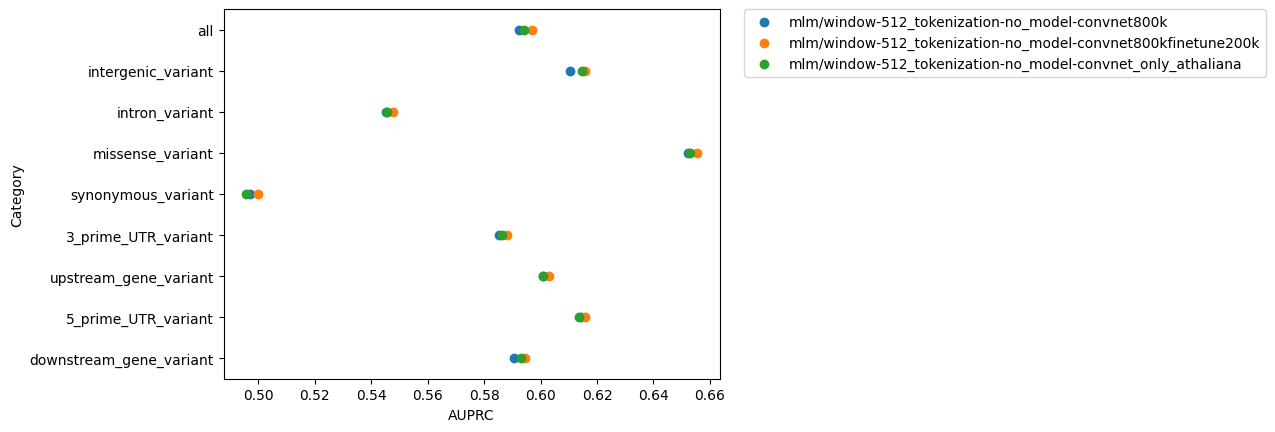

In [19]:
sns.pointplot(
    y="Category",
    x="AUPRC",
    hue="Model",
    data=results_auprc,
    join=False,
    scale=0.8,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("auprc.pdf", bbox_inches='tight')

In [83]:
#df1 = pd.read_parquet(f"../plantbert/chromatin/vep_full_half1_DNABERT.parquet")
#df2 = pd.read_parquet(f"../plantbert/chromatin/vep_full_half2_DNABERT.parquet")
#df = pd.concat([df1, df2], ignore_index=True)
#df.to_parquet("../plantbert/chromatin/vep_full_DNABERT.parquet", index=False)

In [4]:
df = compute_vep_scores("mlm/window-512_tokenization-no_model-convnet800kfinetune200k")[1]
#df = compute_vep_scores("PhyloP")[1]
df

mlm/window-512_tokenization-no_model-convnet800kfinetune200k
Rare      512513
Common    394733
Name: Status, dtype: int64


,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,model_score
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.445963,0.180943,0.000041,-2.247958,Common,1.445963
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.122714,0.000958,0.005789,-0.031569,Rare,-1.122714
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.328421,0.000941,0.004241,0.006849,Rare,0.328421
5,Chr5,538,C,T,2,2158,AT5G01010.2,4456,intergenic_variant,-0.043589,0.000927,0.001401,-1.437007,Rare,-0.043589
6,Chr5,540,T,G,2,2194,AT5G01010.2,4454,intergenic_variant,-2.484268,0.000912,0.001881,0.066429,Rare,-2.484268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319359,Chr5,26974850,C,T,2,2028,AT5G67640.1,-4209,intergenic_variant,0.001271,0.000986,0.038742,-0.295663,Rare,0.001271
1319360,Chr5,26974862,G,A,2,2024,AT5G67640.1,-4221,intergenic_variant,1.164779,0.000988,0.440595,0.574454,Rare,1.164779
1319364,Chr5,26974883,A,C,2,2062,AT5G67640.1,-4242,intergenic_variant,0.285308,0.000970,0.029070,0.328652,Rare,0.285308
1319366,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.040504,0.000976,0.000014,-1.248585,Rare,-0.040504


In [101]:
consequence_scores = df.groupby("consequence").agg({"model_score": "mean", "pos": "size"}).rename(columns={"model_score": "mean_model_score", "pos": "counts"}).reset_index()
consequence_scores = consequence_scores[~consequence_scores.consequence.str.contains(',')]
consequence_scores = consequence_scores.sort_values("mean_model_score")
consequence_scores.sort_values("mean_model_score")

,consequence,mean_model_score,counts
451,non_coding_transcript_variant,-4.377555,2
460,splice_donor_variant,-3.151532,316
476,stop_gained,-2.807480,2337
456,splice_acceptor_variant,-2.528256,307
473,start_lost,-2.062667,186
408,missense_variant,-0.441404,126449
139,5_prime_UTR_variant,-0.436345,32502
315,intergenic_variant,-0.411152,258967
435,non_coding_transcript_exon_variant,-0.330648,6396
488,upstream_gene_variant,-0.302749,38330


In [102]:
consequence_scores = consequence_scores[consequence_scores.counts >= 100]
consequence_scores

,consequence,mean_model_score,counts
460,splice_donor_variant,-3.151532,316
476,stop_gained,-2.807480,2337
456,splice_acceptor_variant,-2.528256,307
473,start_lost,-2.062667,186
408,missense_variant,-0.441404,126449
139,5_prime_UTR_variant,-0.436345,32502
315,intergenic_variant,-0.411152,258967
435,non_coding_transcript_exon_variant,-0.330648,6396
488,upstream_gene_variant,-0.302749,38330
480,stop_lost,-0.296917,151


In [103]:
consequence_scores["consequence"] = consequence_scores.consequence + " (n=" + consequence_scores.counts.astype(str) + ")"
consequence_scores

,consequence,mean_model_score,counts
460,splice_donor_variant (n=316),-3.151532,316
476,stop_gained (n=2337),-2.807480,2337
456,splice_acceptor_variant (n=307),-2.528256,307
473,start_lost (n=186),-2.062667,186
408,missense_variant (n=126449),-0.441404,126449
139,5_prime_UTR_variant (n=32502),-0.436345,32502
315,intergenic_variant (n=258967),-0.411152,258967
435,non_coding_transcript_exon_variant (n=6396),-0.330648,6396
488,upstream_gene_variant (n=38330),-0.302749,38330
480,stop_lost (n=151),-0.296917,151


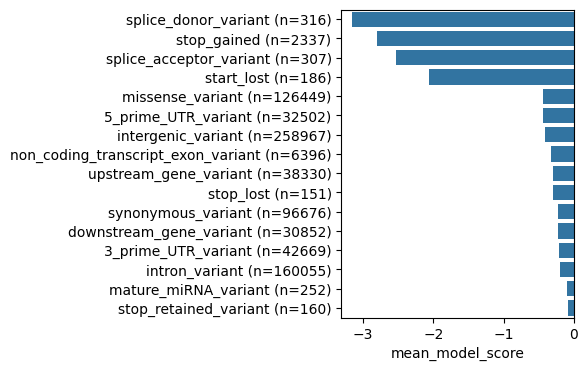

In [109]:
plt.figure(figsize=(3,4))
sns.barplot(
    data=consequence_scores,
    y="consequence", x="mean_model_score", color="C0"
);
plt.ylabel("")
plt.savefig("model_score_by_consequence.svg", bbox_inches='tight')

In [5]:
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,model_score
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.445963,0.180943,0.000041,-2.247958,Common,1.445963
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.122714,0.000958,0.005789,-0.031569,Rare,-1.122714
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.328421,0.000941,0.004241,0.006849,Rare,0.328421
5,Chr5,538,C,T,2,2158,AT5G01010.2,4456,intergenic_variant,-0.043589,0.000927,0.001401,-1.437007,Rare,-0.043589
6,Chr5,540,T,G,2,2194,AT5G01010.2,4454,intergenic_variant,-2.484268,0.000912,0.001881,0.066429,Rare,-2.484268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319359,Chr5,26974850,C,T,2,2028,AT5G67640.1,-4209,intergenic_variant,0.001271,0.000986,0.038742,-0.295663,Rare,0.001271
1319360,Chr5,26974862,G,A,2,2024,AT5G67640.1,-4221,intergenic_variant,1.164779,0.000988,0.440595,0.574454,Rare,1.164779
1319364,Chr5,26974883,A,C,2,2062,AT5G67640.1,-4242,intergenic_variant,0.285308,0.000970,0.029070,0.328652,Rare,0.285308
1319366,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.040504,0.000976,0.000014,-1.248585,Rare,-0.040504


In [7]:
odds_ratio, p_value, min_counts = compute_odds_ratio(df[df.consequence=="upstream_gene_variant"], 1e-3, print_table=True)
odds_ratio, p_value, min_counts

Status  ModelScoreTier
Common  High              16232
        Low                   6
Rare    High              22059
        Low                  33
dtype: int64


(4.047146289496351, 0.00030769630324283307, 6)